In [420]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy import spatial

In [3]:
data_path = '../data/bird_data'
n_images = 21

In [139]:
name1 = "0004"
name2 = "0005"

In [140]:
img1 = plt.imread(os.path.join(data_path, "images", name1+'.ppm'))
img2 = plt.imread(os.path.join(data_path, "images", name2+'.ppm'))

In [141]:
h, w, _ = img1.shape

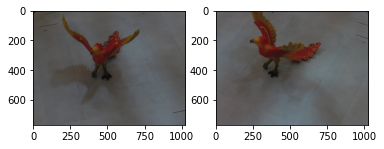

In [142]:
f = plt.figure()
f.add_subplot(1,2,1)
plt.imshow(img1)
f.add_subplot(1,2,2)
plt.imshow(img2)
plt.show()

In [401]:
# x = (X, Y, w)
def x_to_img_coordinates(x):
    return int(x[0]/x[2]), int(x[1]/x[2])

In [407]:
# x = (X, Y, w)
def x_to_np_coordinates(x):
    i, j = x_to_img_coordinates(x)
    return j, i

In [402]:
# x = (X, Y, w)
def scatter(x):
    i, j = x_to_img_coordinates(x)
    plt.scatter([i], [j], c='r')

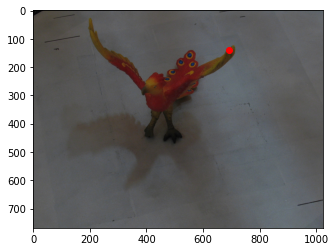

In [436]:
x = np.array([690, 140, 1])

plt.imshow(img1)
scatter(x)
plt.show()

In [437]:
def epipolar_y(x, l):
    return (-l[2] - l[0]*x)/l[1]

In [438]:
def plot_epipolar_line(img, l, show=True):
    plt.imshow(img)
    i1,j1 = x_to_img_coordinates([0,  epipolar_y(0, l), 1])
    i2,j2 = x_to_img_coordinates([w-1,  epipolar_y(w-1, l), 1])
    plt.plot([i1,i2], [j1, j2], 'r')
    plt.xlim([0,w-1])
    plt.ylim([h-1,0])
    if show:
        plt.show()

In [439]:
f1 = os.path.join(data_path, "calib", name1+'.txt')
f2 = os.path.join(data_path, "calib", name2+'.txt')

In [440]:
P1 = np.loadtxt(f1, skiprows=1)
P2 = np.loadtxt(f2, skiprows=1)

In [441]:
def lie_matrix(v):
    M = np.zeros((3,3))
    M[0,1] = -v[2]
    M[0,2] =  v[1]
    M[1,0] =  v[2]
    M[1,2] = -v[0]
    M[2,0] = -v[1]
    M[2,1] =  v[0]
    return M

In [442]:
def compute_F(P1, P2):
    P1x_ = np.linalg.inv(P1[:,:3])
    return (lie_matrix(P2[:,-1]) - lie_matrix(P2[:,:3] @ P1x_ @ P1[:,-1])) @ P2[:,:3] @ P1x_

In [443]:
F = compute_F(P1, P2)

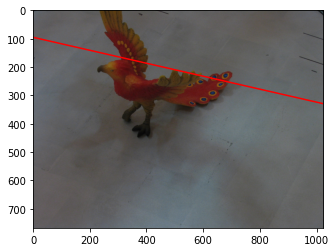

In [444]:
plot_epipolar_line(img2, F @ x)

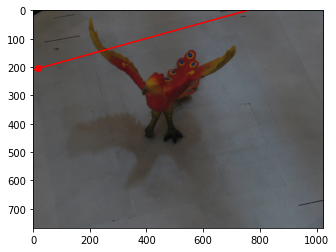

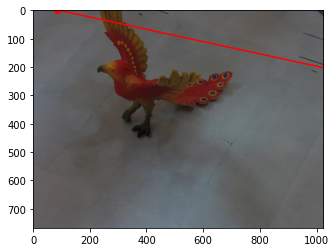

In [445]:
X = np.array([10,0,0,1])

#plt.imshow(img1)
#scatter(P1 @ X)
#plt.show()

plot_epipolar_line(img1, F.T @ P2 @ X, show=False)
scatter(P1 @ X)
plt.show()

#plt.imshow(img2)
plot_epipolar_line(img2, F @ P1 @ X, show=False)
scatter(P2 @ X)
plt.show()

In [389]:
X1 = np.concatenate((np.linalg.inv(P1[:,:3]) @ x, np.array([0])))

In [390]:
P1 @ X1

array([690., 140.,   1.])

In [391]:
X2 = np.concatenate((np.linalg.inv(P1[:,:3]) @ (x - P1[:,-1]), np.array([1])))

In [392]:
P1 @ X2

array([690., 140.,   1.])

In [394]:
l = F @ x

In [446]:
def find_x2(x1, F, img1, img2, kernel_size=[5,5]):
    padding_i, padding_j = kernel_size[0]//2, kernel_size[1]//2
    
    i, j = x_to_np_coordinates(x1)
    patch1 = img1[(i-padding_i):(i+padding_i+1), (j-padding_j):(j+padding_j+1)].flatten()
    
    shortest_distance = 2
    best_x2 = None
    l = F @ x1
    distances = []
    for x in range(padding_i, w-padding_i):
        y = epipolar_y(x, l)
        i, j = x_to_np_coordinates([x, y, 1])
        if j > padding_j and j < h - padding_j:
            patch2 = img2[(i-padding_i):(i+padding_i+1), (j-padding_j):(j+padding_j+1)].flatten()
            distance = spatial.distance.cosine(patch1, patch2)
            distances.append(distance)
            if distance < shortest_distance:
                shortest_distance = distance
                best_x2 = [x, y, 1]
    plt.plot(distances)
    plt.show()
    return best_x2

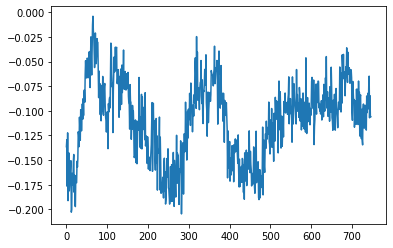

In [452]:
x2 = find_x2(x, F, img1, img2, kernel_size=[20,20])

In [453]:
x2

[293, 162.935481085563, 1]

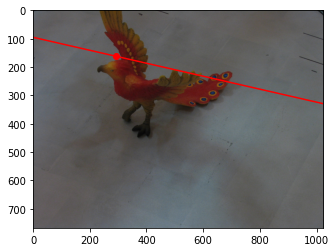

In [454]:
plot_epipolar_line(img2, F @ x, show=False)
scatter(x2)
plt.show()